In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import json
import tqdm
import pathlib

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib


In [0]:
train_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/1751c781501264f1f49537054f901dc2/activity_train.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip", dtype=np.float32)
test_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/511e69d37295aabf89fc0cce5e8a2de5/activity_test.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip", dtype=np.float32)
activity_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")
atactic_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")

In [0]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [0]:
data.drop(['f28'], axis=1, inplace=True)
full_data = data

In [0]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

FTS_COLS = activity_data.columns[1:]
TARGET = "activity"

In [0]:
activity_data

In [0]:
##### 0D model #####
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 512
WINDOW = 0

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
y_cv =  cv_data[TARGET].values

model = keras.Sequential([
      layers.Input(shape=len(FTS_COLS)),
      layers.Dense(70),
      layers.Dropout(0.4),
      layers.Dense(43, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(16),
      layers.Dropout(0.1),
      layers.Dense(4),
      layers.Dense(1)
    ])
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

model.reset_states()
model.summary()

model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
          #keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
#model = tf.keras.models.load_model('my_checkpoint.h5')

tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values, cv_preds.values):.2f}%")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                3920      
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3053      
_________________________________________________________________
dropout_1 (Dropout)          (None, 43)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                704       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 6

In [0]:
activity_data

(737036.0, 737043.75)

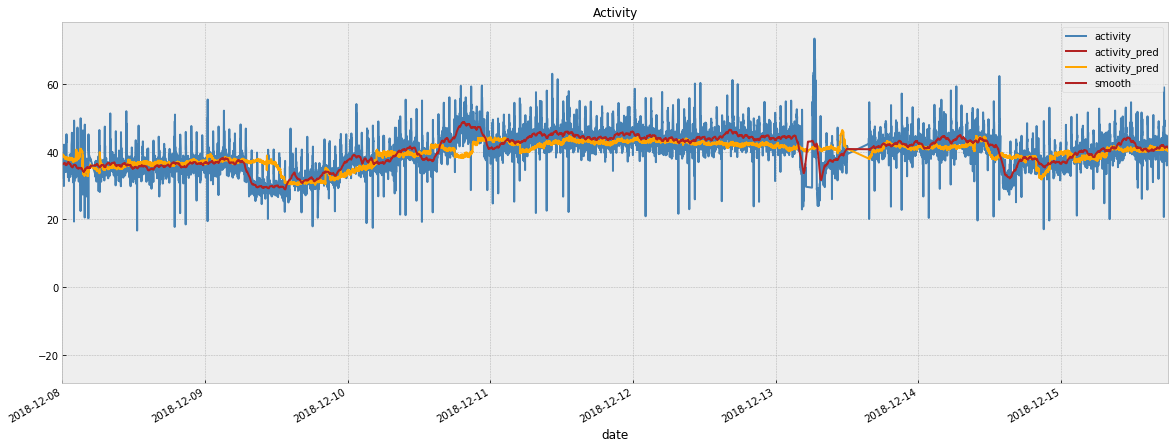

In [0]:
import scipy.signal as sig

plt.rcParams['figure.figsize'] = (16, 6)

tr_data["activity"].plot(ax=plt.gca(), c="steelblue")
cv_data["activity"].plot(ax=plt.gca(), c="steelblue", label="")
tr_preds.plot(ax=plt.gca(), c="firebrick")
cv_preds.plot(ax=plt.gca(), c="orange")

#smooth = pd.Series(cv_data.activity.rolling(25, min_periods=1).mean().values , index=cv_data.index, name="smooth")
smooth = pd.Series(sig.savgol_filter(cv_data.activity.values, 91, 1) , index=cv_data.index, name="smooth")
smooth.plot(c='firebrick')

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)
#plt.xlim('2018-11-01 00:00', '2018-11-02 00:00')
#plt.xlim('2018-11-06 06:00', '2018-11-06 12:00')
#plt.xlim('2018-10-23 00:00', '2018-12-31 05:00')
plt.xlim('2018-12-08 00:00', '2018-12-15 18:00')


Text(0, 0.5, 'predicted activity')

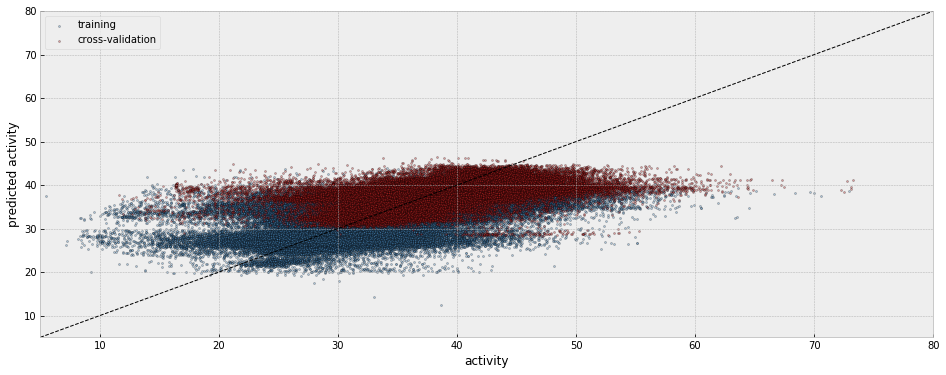

In [0]:
plt.scatter(tr_data.activity.values[WINDOW:], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data.activity.values[WINDOW:], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [0]:
import scipy.signal as sig

tf.keras.backend.clear_session()

EPOCHS = 500
WINDOW = 60
BS = 1024

#### [samples, timesteps, features] #####
model = keras.Sequential([
  layers.Input(shape=(WINDOW, len(FTS_COLS))),
  layers.Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'),
  layers.MaxPooling1D(pool_size=2),
  layers.Conv1D(16, kernel_size=3, strides=1, padding='same', activation='relu'),
  layers.MaxPooling1D(pool_size=2),
  layers.Conv1D(4, kernel_size=3, strides=1, padding='same', activation='relu'),
  layers.MaxPooling1D(pool_size=2),
  layers.Flatten(),
  layers.Dense(32),
  layers.Dense(1)
])
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
y_cv =  cv_data[TARGET].values

gen_trn = tf.keras.preprocessing.sequence.TimeseriesGenerator( trn, (np.roll(y_trn, 1) - y_trn.mean())/y_trn.std(), length=WINDOW, stride=1, batch_size=BS, shuffle=False)
gen_cv = tf.keras.preprocessing.sequence.TimeseriesGenerator( cvn, (np.roll(y_cv, 1) - y_trn.mean())/y_trn.std(), length=WINDOW, stride=1, batch_size=BS, shuffle=False)

history = model.fit_generator(gen_trn,
          epochs=EPOCHS,
          shuffle=False,
          use_multiprocessing=True,
          validation_data=gen_cv,
          callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
          #keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
model.reset_states()
#model = tf.keras.models.load_model('my_checkpoint.h5')

plot_history(history)

tr_preds = model.predict_generator(gen_trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict_generator(gen_cv, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index[WINDOW:], name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index[WINDOW:], name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values[WINDOW:], tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values[WINDOW:], cv_preds.values):.2f}%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 66)                3696      
_________________________________________________________________
dropout (Dropout)            (None, 66)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2881      
_________________________________________________________________
dropout_1 (Dropout)          (None, 43)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                704       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 6

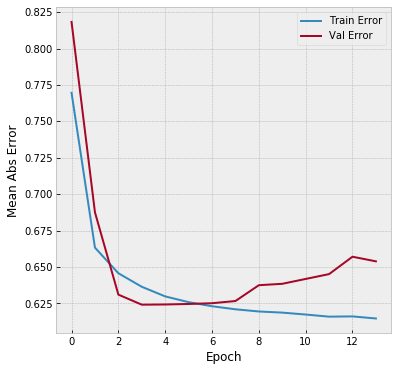

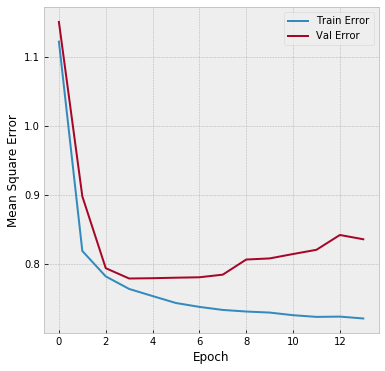

MAPE (training set): 10.19%
MAPE (cross-validation set): 8.93%


In [7]:
##### 0D model #####
tf.keras.backend.clear_session()

EPOCHS = 100
BS = 512
WINDOW = 0

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
y_cv =  cv_data[TARGET].values

model = keras.Sequential([
      layers.Input(shape=len(FTS_COLS)),
      layers.Dense(70), 
      layers.Dropout(0.4),
      layers.Dense(43, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(16), #kernel_regularizer=keras.regularizers.l2(0.02)),
      layers.Dropout(0.1),
      layers.Dense(4),
      layers.Dense(1)
    ])
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, metrics=['mae', 'mse'], loss='mse')

model.reset_states()
model.summary()

'''
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
'''
lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0)

history = model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=0,
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
          lr_schedule
          #keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
#model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

plot_history(history)

tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values, cv_preds.values):.2f}%")


[1e-07, 1, 0, 2]

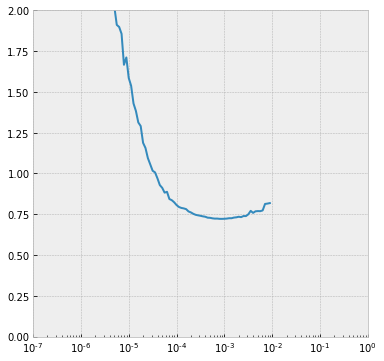

In [10]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1, 0, 2])
  plt.xlabel('LR')
  plt.ylabel('Error')

mape     0.09033
n1      70.00000
n2      42.00000
n3      22.00000
n4       6.00000

mape     0.090103
n1      70.000000
n2      42.000000
n3      16.000000
n4       4.000000

mape     0.090396
n1      66.000000
n2      35.000000
n3      18.000000
n4       8.000000

....66 7 10 4

(737036.0, 737043.75)

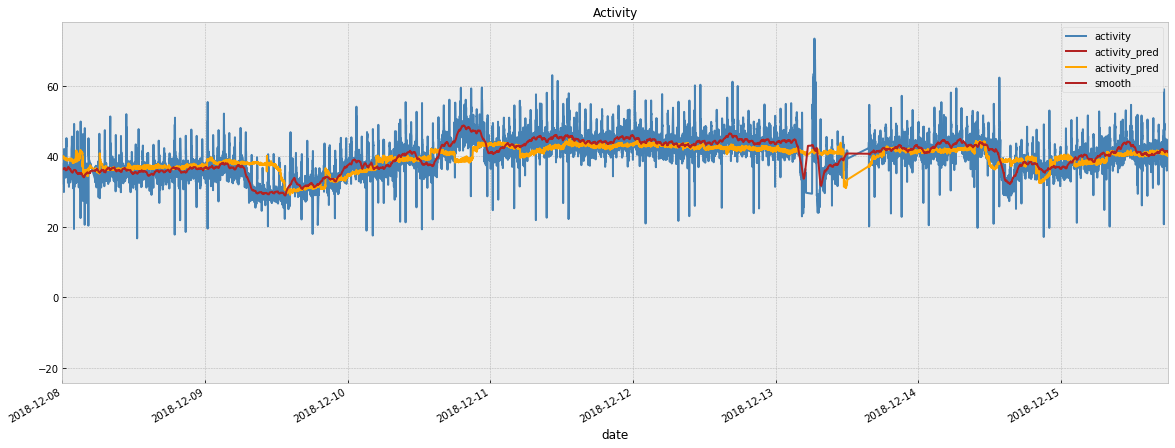

In [0]:
import scipy.signal as sig

plt.rcParams['figure.figsize'] = (16, 6)

tr_data[TARGET].plot(ax=plt.gca(), c="steelblue")
cv_data[TARGET].plot(ax=plt.gca(), c="steelblue", label="")
tr_preds.plot(ax=plt.gca(), c="firebrick")
cv_preds.plot(ax=plt.gca(), c="orange")

#smooth = pd.Series(cv_data.activity.rolling(25, min_periods=1).mean().values , index=cv_data.index, name="smooth")
smooth = pd.Series(sig.savgol_filter(cv_data.activity.values, 91, 1) , index=cv_data.index, name="smooth")
smooth.plot(c='firebrick')
#tr_data.activity.rolling(5, min_periods=1).mean().plot(c='blue')

plt.legend(loc=0)
plt.tight_layout()
plt.title(TARGET, fontsize=12)
#plt.xlim('2018-11-01 00:00', '2018-11-02 00:00')
#plt.xlim('2018-11-06 06:00', '2018-11-06 12:00')

#plt.xlim('2018-10-23 00:00', '2018-12-31 05:00')
plt.xlim('2018-12-08 00:00', '2018-12-15 18:00')


Text(0, 0.5, 'predicted activity')

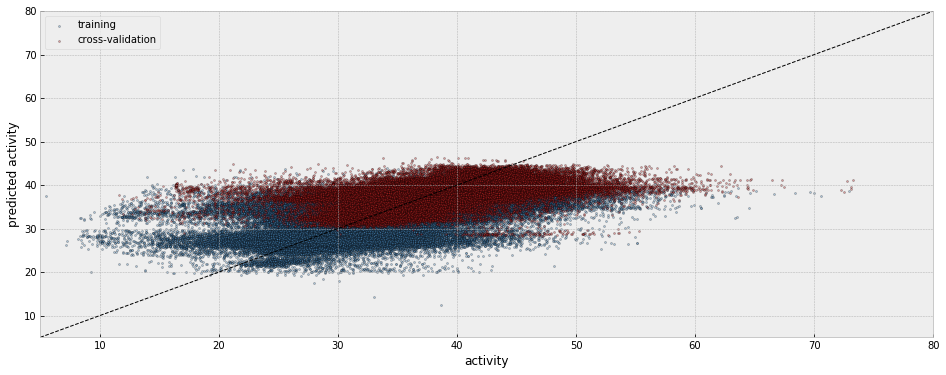

In [0]:
plt.scatter(tr_data.activity.values[WINDOW:], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data.activity.values[WINDOW:], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [0]:
print(f"MAPE (training set): {100 * mape(tr_data[TARGET].values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data[TARGET].values, cv_preds.values):.2f}%")

MAPE (training set): 10.12%
MAPE (cross-validation set): 9.35%


In [0]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * tr_data[TARGET].std() + tr_data[TARGET].mean()

ts_preds = pd.DataFrame(ts_preds, columns=[TARGET], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv(DATA_DIR.joinpath("activity_nn_baseline.csv"))

feature;description;units	 
f0;Уровень донора в нефрасe ;%	 
f1;Тем-ра пропилена к к.201;К	 
f2;Расход пропилена к R1;л/c	 
f3;Расход водорода к R1;л/c	 
f4;Расход катализатора в R1;л/c	 
f5;Расход донора к R1;л/c	 
f6;Давление пропилена на входе;Па	 
f7;Давление в газовой фазе реактора R1;Па	 
f8;R1	Объемная доля пропана;%
f9;R1	Объемная доля водорода;%
f10;Расход пропилена к R2;л/c	 
f11;Расход водорода к R2;л/c	 
f12;Расход катализатора в R2;л/c	 
f13;Расход донора к R2;л/c	 
f14;Давление в газовой фазе реактора R2;Па	 
f15;R2	Объемная доля пропана;%
f16;R2	Объемная доля водорода;%
f17;Температура реакционной среды в R1;К	 
f18;Температура реакционной среды в R2;К	 
f19;Температура реакционной среды в R3;К	 
f20;Расход нефраса к R1;л/c	 
f21;Расход нефраса к R2;л/c	 
f22;Расход ТЭА к R1;л/c	 
f23;Расход ТЭА к R2;л/c	 
f24;Температура в D219;К	 
f25;R1	Газоанализатор водорода;%
f26;R2	Газоанализатор водорода;%
f27;R3	Газоанализатор водорода;%
f28;ТЭА;л/c	 
f29;R1	Ток мешалки;А
f30;R3	Ток мешалки;А
f31;R2	Ток мешалки;А
f32;R1	Уровень;%
f33;R3	Уровень;%
f34;R2	Уровень;%
f35;Давление азота к E3B;Па	 
f36;R3	Перепад давления масло : газ;Па
f37;Давление сдувок на этилен;Па	 
f38;Температура деминерализованной воды;К	 
f39;Температура суспензии внизу R1;К	 
f40;Температура суспензии внизу R3;К	 
f41;Температура суспензии в центре R1;К	 
f42;Температура воздуха;К	 
f43;Атмосферное давление;Па	 
f44;Влажность воздуха;%	 
f45;Температура суспензии в центре R3;К	 
f46;Температура R1 длинный терм.;К	 
f47;Температура R1 короткий терм.;К	 
f48;Температура R3 длинный терм.;К	 
f49;Температура R3 короткий терм.;К	 
f50;Температура суспензии в центре R2;К	 
f51;Температура R2 длинный терм.;К	 
f52;Температура R2 короткий терм.;К	 
f53;Д18А Датчики веса;кг	 
f54;Д19А Датчики веса;кг	 
f55;Д20А Датчики веса;кг	 